In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import json

# Data Exploration
##### Will be using two datasets from huggingface so we need to understand how each of the data is formated and combine both of them in one data structure
* tweet_sentiment_multilingual uses 2:positive, 1:neutral, 0:negative format
* dz-sentiment-yt-comments uses 2:postive, 1:neutral, 0:negative format
##### no need to change any of the labels 

In [2]:
# Explore the first data source
# Load the data
data = pd.read_csv('data\dz-sentiment-yt-comments\ADArabic-3labels-50016.csv', sep=',', header=None)
# Print the first 5 rows of the dataframe.
print(data.head())
print('-'*50)
# Print the statistics of the data
print(data.describe())
print('-'*50)
# Check for missing values
print(data.isna().sum())


                                                   0      1
0                                               text  label
1       يا سي كريم الرئيس الذى تشتكى له هو أصله معين      1
2  حتى السعودية قاتلكم ماكمش عرب،واش بقا يا بعاصي...      0
3                              Thbliiii bravo souade      2
4          تحيالي ناس بن يزقن و لقصور في الغيبة 🌹🇩🇿🤣      2
--------------------------------------------------
            0      1
count   50017  50017
unique  50017      4
top      text      2
freq        1  21847
--------------------------------------------------
0    0
1    0
dtype: int64


In [3]:
jsonl_data = []
with open('data\\tweet_sentiment_multilingual\\train.jsonl', 'r', encoding='utf-8') as jsonl_file:
    for line in jsonl_file:
        json_line = json.loads(line)
        jsonl_data.append({'text': json_line['text'], 'label': json_line['label']})

print(jsonl_data[0])
print(jsonl_data[1])

{'text': 'RT @user: @user @user   وصلنا لاقتصاد اسوء من سوريا والعراق ومن غير حربانجاز ده ولا مش انجاز يا متعلمين يا بتوع المدا…', 'label': '0'}
{'text': 'كاني ويست، دريك، نيكي، بيونسيه، قاقا http', 'label': '1'}


# Data Preprocessing

In [4]:
# method to load JSONL data
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as jsonl_file:
        for line in jsonl_file:
            json_line = json.loads(line)
            data.append({'text': json_line['text'], 'label': json_line['label']})
    return data
# Load JSONL data from three files
jsonl_data1 = load_jsonl('data\\tweet_sentiment_multilingual\\test.jsonl')
jsonl_data2 = load_jsonl('data\\tweet_sentiment_multilingual\\train.jsonl')
jsonl_data3 = load_jsonl('data\\tweet_sentiment_multilingual\\validation.jsonl')
# Load CSV data
csv_data = []
with open('data\\dz-sentiment-yt-comments\\ADArabic-3labels-50016.csv', 'r', encoding='utf-8') as csv_file:
    reader = csv.reader(csv_file)
    next(reader, None)  # Skip the header if there is one
    for row in reader:
        text = row[0]  # Assuming 'text' is in the first column
        label = row[1]  # Assuming 'label' is in the second column
        csv_data.append({'text': text, 'label': label})

# Combine the datasets
combined_data = jsonl_data1 + jsonl_data2 + jsonl_data2 + csv_data


# Define the labels and sentences
sentences = [data['text'] for data in combined_data]
labels = [data['label'] for data in combined_data]
# Convert labels to integers
labels = [int(label) for label in labels]
# Convert labels to one-hot encodings
labels = tf.keras.utils.to_categorical(labels, num_classes=3) # converting it to numpy array instead is also an option
# Print the first five sentences and labels
print(f"First five sentences:\n\n{sentences[:5]}")
print(f"First five labels:\n\n{labels[:5]}")


First five sentences:

['نوال الزغبي (الشاب خالد ليس عالمي) هههههههه أتفرجي على ها الفيديو يا مبتدئة http vía @user', 'تقول نوال الزغبي : http', 'نوال الزغبي لطيفه الفنانه الوحيده اللي كل الفيديو كليبات تبعها ماتسبب تلوث بصري ولا سمعي لو صوتها اقل من عادي', 'لما قالت نوال الزغبي لابقلها هاللقب فرحوا فانزها 😂😂😂كان لازم ياخدوها اهانة مش ثناء http', 'الفنانة نوال الزغبي سنة 90 http']
First five labels:

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [5]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets this also shuffles the data
training_sentences, validation_sentences, training_labels, validation_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# Tokenize the sentences
def tokenize(sentences, vocab_size, oov_token, trunc_type, padding_type, max_length):
    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
    tokenizer.fit_on_texts(sentences)
    word_index = tokenizer.word_index
    sequences = tokenizer.texts_to_sequences(sentences)
    padded = pad_sequences(sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)
    return sequences, padded, word_index, tokenizer

vocab_size = 10000
oov_token = "<OOV>"
trunc_type = 'post'
padding_type = 'post'
embedding_dim = 16
max_length = 50 # tweets don't usaually exceed 50 words

train_sequences, train_padded, word_index, tokenizer = tokenize(training_sentences, vocab_size, oov_token, trunc_type, padding_type, max_length)

test_padded = tokenizer.texts_to_sequences(validation_sentences)
test_padded = pad_sequences(test_padded, padding=padding_type, truncating=trunc_type, maxlen=max_length)

print(f"First sentence:\n\n {training_sentences[0]}")
print(f"First sentence tokenized:\n\n {train_sequences[0]}")
print(f"First sentence padded:\n\n {train_padded[0]}")
print(f"padded shape:\n\n {train_padded.shape}")
print("-"*50)
print(f"First validation sentence:\n\n {validation_sentences[0]}")
print(f"First validation sentence tokenized:\n\n {test_padded[0]}")
print(f"padded shape:\n\n {test_padded.shape}")



First sentence:

 هل تعلم ان النقطه (. )هيه نفسها 👈 (*)بس مسويه شعرها مثل ميريام فارس 🌚😂✋
First sentence tokenized:

 [95, 1423, 18, 1, 1, 1861, 1, 407, 1, 4665, 170, 821, 488, 1]
First sentence padded:

 [  95 1423   18    1    1 1861    1  407    1 4665  170  821  488    1
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
padded shape:

 (43651, 50)
--------------------------------------------------
First validation sentence:

 شيئ تقشعر له الأبدان
First validation sentence tokenized:

 [1140    1  104    1    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
padded shape:

 (10913, 50)


## Training The Model

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    #Three output nodes, one for each label
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 dropout (Dropout)           (None, 50, 16)            0         
                                                                 
 conv1d (Conv1D)             (None, 46, 64)            5184      
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                      

In [8]:
history = model.fit(train_padded, training_labels, epochs=20, validation_data=(test_padded, validation_labels), verbose=2)

Epoch 1/20


1365/1365 - 4s - loss: 0.5014 - accuracy: 0.6048 - val_loss: 0.4355 - val_accuracy: 0.6710 - 4s/epoch - 3ms/step
Epoch 2/20
1365/1365 - 3s - loss: 0.3778 - accuracy: 0.7319 - val_loss: 0.3901 - val_accuracy: 0.7296 - 3s/epoch - 2ms/step
Epoch 3/20
1365/1365 - 3s - loss: 0.3238 - accuracy: 0.7825 - val_loss: 0.3800 - val_accuracy: 0.7374 - 3s/epoch - 2ms/step
Epoch 4/20
1365/1365 - 3s - loss: 0.2929 - accuracy: 0.8054 - val_loss: 0.4001 - val_accuracy: 0.7327 - 3s/epoch - 2ms/step
Epoch 5/20
1365/1365 - 3s - loss: 0.2707 - accuracy: 0.8234 - val_loss: 0.3994 - val_accuracy: 0.7348 - 3s/epoch - 2ms/step
Epoch 6/20
1365/1365 - 3s - loss: 0.2508 - accuracy: 0.8378 - val_loss: 0.4141 - val_accuracy: 0.7330 - 3s/epoch - 2ms/step
Epoch 7/20
1365/1365 - 3s - loss: 0.2340 - accuracy: 0.8497 - val_loss: 0.4384 - val_accuracy: 0.7288 - 3s/epoch - 2ms/step
Epoch 8/20
1365/1365 - 3s - loss: 0.2173 - accuracy: 0.8601 - val_loss: 0.4536 - val_accuracy: 0.7307 - 3s/epoch - 2ms/step
Epoch 

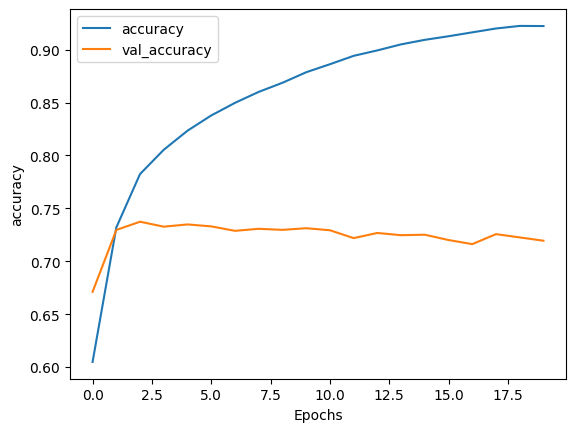

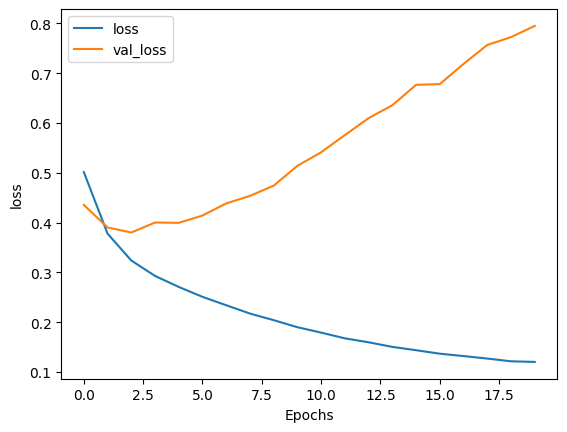

In [9]:
# plot the accuracy and loss
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Saving the model and tokenizer to use in Gradio interface

In [11]:
# save the model')
history.model.save('model.keras')
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)